In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\barla\\OneDrive\\Desktop\\Academia\\Data Science and Economics\\Datasets')
os.getcwd()

'C:\\Users\\barla\\OneDrive\\Desktop\\Academia\\Data Science and Economics\\Datasets'

In [64]:
data=pd.read_csv('champangesales.csv')

In [65]:
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [66]:
print(data.isnull().sum())

print(data.isnull())

# we have some null values, we should remove them. indices 105 and 106.

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64
     Month  Perrin Freres monthly champagne sales millions ?64-?72
0    False                                              False     
1    False                                              False     
2    False                                              False     
3    False                                              False     
4    False                                              False     
..     ...                                                ...     
102  False                                              False     
103  False                                              False     
104  False                                              False     
105   True                                               True     
106  False                                               True     

[107 rows x 2 columns]


In [67]:
data.columns=['Month','Sales']
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [68]:
data.drop(106, axis = 0, inplace= True)
data.drop(105, axis = 0, inplace= True)
data.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [69]:
data.info()
#Since we are working with time-series, we should convert the time variable into datetime data type.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [70]:
data['Month']=pd.to_datetime(data['Month'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   105 non-null    datetime64[ns]
 1   Sales   105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [106]:
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [72]:
data.set_index('Month',inplace=True)


In [76]:
print(data.head())
print(data.describe())


             Sales
Month             
1964-01-01  2815.0
1964-02-01  2672.0
1964-03-01  2755.0
1964-04-01  2721.0
1964-05-01  2946.0
              Sales
count    105.000000
mean    4761.152381
std     2553.502601
min     1413.000000
25%     3113.000000
50%     4217.000000
75%     5221.000000
max    13916.000000


<AxesSubplot:xlabel='Month'>

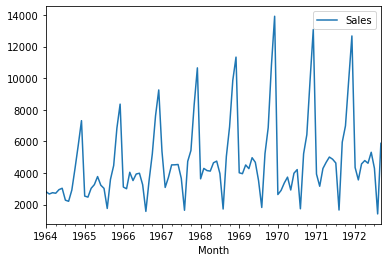

In [90]:
data.plot()

#The graph tells us that the mean and the variance are not constant over time, so it does not really look like a stationary 
#series. There seems to be seasonal hits, towards the end of each year, it can be observed that  the sales increases 
#and then dramatically decreases. The economic interpretation for that might be that due to christmas and newyear celebrations,
#people tend to buy more champagne.



In [102]:
#Let's test for stationarity

from statsmodels.tsa.stattools import adfuller

#I will use dickey-fuller test for it



def adfuller_test(sales):
    result=adfuller(sales)
    labels=['ADF test statistic','p-value','Lags Used','Number of observations used']
    for value,label in zip(result,labels):
        print(label+ ':' + str(value))
    if result[1]<=0.05:
            print('P value is smaller than 0.05, Ho that the series have a unit root is rejected')
    else:
            print('P value is greater than 0.05, Ho that the series have a unit root is not rejected.')
    

In [103]:
adfuller_test(data['Sales'])

#The series are not stationary, we should first-difference it before applying the ARIMA models.

ADF test statistic:-1.8335930563276237
p-value:0.3639157716602447
Lags Used:11
Number of observations used:93
P value is greater than 0.05, Ho that the series have a unit root is not rejected.


In [109]:
data['SalesFirstDiffed'] = data['Sales']-data['Sales'].shift(1)

data['Seasonal First Difference']=data['Sales']-data['Sales'].shift(12)

data.head()

,Sales,SalesFirstDiffed,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [112]:
#Now we should apply Dickey-Fuller test again to see if the series are not stationary.

adfuller_test(data['Seasonal First Difference'].dropna())



ADF test statistic:-7.626619157213163
p-value:2.060579696813685e-11
Lags Used:0
Number of observations used:92
P value is smaller than 0.05, Ho that the series have a unit root is rejected


<AxesSubplot:xlabel='Month'>

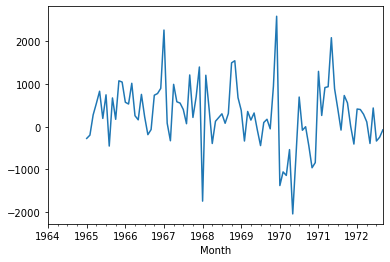

In [114]:
#Null Hypothesis that the series have a unit root is rejected.Let's plot it again

data['Seasonal First Difference'].plot()

#Now, we can clearly see that the dependence on time is removed, the values are clustering around a constant mean.



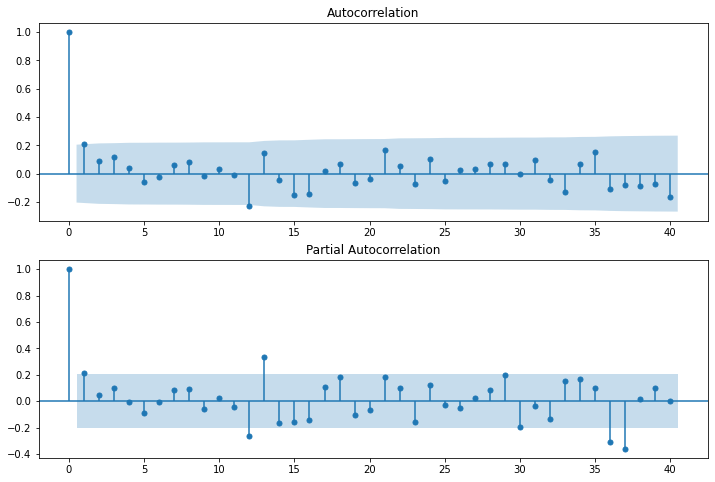

In [126]:
#We now need to do the model selection that fits the best our data. For this, we will check the ACF and PACF
#We should choose our models to be parsimonuos, we can't use as much as lags we want, since the more lags used the more
#variance we have which will then reduce the predictive power of our models.
import statsmodels.api as sm


fig= plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].iloc[13:], lags = 40, ax = ax1)# first 12 rows are NAN.
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].iloc[13:], lags =40, ax= ax2)

#So we used 40 lags for the identifaction of our models through the Autocorrelation and PartialAutoCorrelation Function.
#The ACF function has two hits at lag 1 and 2 and no other hits afterwards and PACF keeps changing the sign,
#so it should be a ARMA(1,1) but we also know that there is a seasonality in our data so we might go for SARIMAX models.
#However, looking at the graph and choosing accordingly a model is not the best thing we could do.
#I will also use model selection criterion, in particular BIC to validate the model we choose.
#So we have two candidates, SARIMAX(1,1,1) and ARMA(1,1).



In [144]:
import warnings
warnings.filterwarnings('ignore')
modelsarimax=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1,1,1), seasonal_order=(1,1,1,12))
modelsarimax_fit=modelsarimax.fit()
modelsarimax_fit.summary()

print(modelsarimax_fit.summary())

modelarma=ARMA(data['Sales'],order=(1,1))
modelarma_fit=modelarma.fit()
print(modelarma_fit.summary())

#as we can see, BIC information criteria provided much smaller values for SARIMAX, so we will go for it.
#The Sarimax model is 0.2790(AR)- 0.9494(ma) -0.4544(ars) + 0.2450(mas) + epsilon, where epsilon is a white noise.

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Wed, 20 Jan 2021   AIC                           1486.804
Time:                                    23:26:59   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043   

<AxesSubplot:xlabel='Month'>

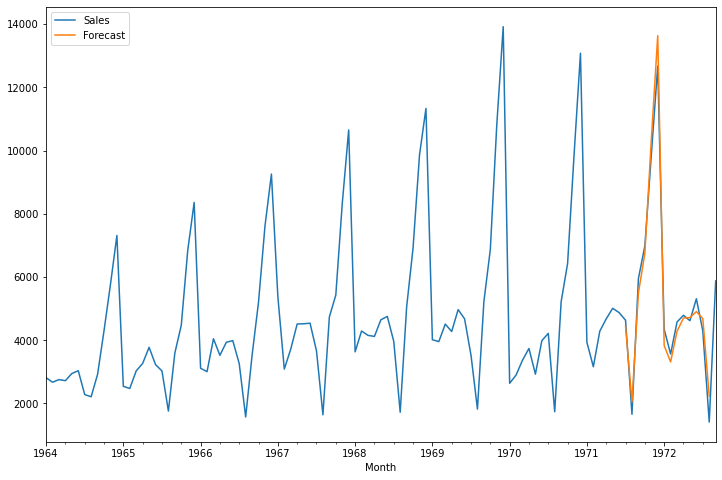

In [146]:
data['Forecast']=modelsarimax_fit.predict(start=90, end= 103, dynamic=True)
data[['Sales','Forecast']].plot(figsize=(12,8))


#so our estimation looks pretty good.

In [147]:
#Let's create future estimation values and graph them all.

from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [149]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)


In [157]:
future_datest_df.tail()



,Sales,SalesFirstDiffed,Seasonal First Difference,Forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [151]:
future_df=pd.concat([data,future_datest_df])

<AxesSubplot:>

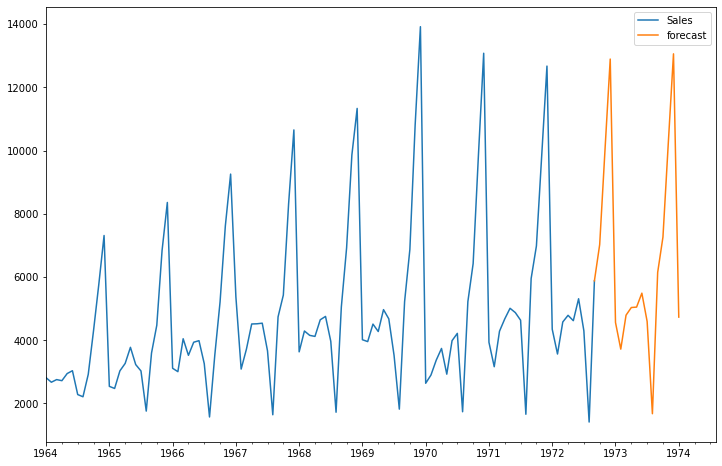

In [153]:
future_df['forecast'] = modelsarimax_fit.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

#the future estimation from 1972 to 1974.